In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

while 'jupyter' in os.getcwd():
    os.chdir("../")

!pwd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
/Users/msat/projects/white-box-nn


In [2]:
import torch
from torch import einsum, nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
import torch.nn.functional as F

import pandas as pd
import seaborn as sn
import numpy as np
import math
import random
import cv2
import matplotlib.pyplot as plt

from lib.datamodules import MNISTDataModule
from lib.helpers import hh
from lib.lightning_modules.cls_module import ClsModule

from lib.modules.augment import Noise
from lib.modules.sf_model import get_model, visualize_processing_steps
from lib.modules.sf_layers import TwoStepFunction


BATCH_SIZE = 200

# LABELS = None
LABELS = [3, 5]
N_CLASSES = len(LABELS) if LABELS else 10

prefix = "mnist"
IMG_SHAPE = (1, 28, 28)
EPS = 0.3
STEP_SIZE = 0.1

VERSION = 0
LOGS_DIR = f"logs/{prefix}_sf_model/"
MODEL_SAVE_PATH = f"models/{prefix}/wbnn_state_dict_{VERSION}.pt"

torch.set_printoptions(linewidth=100)

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
device

'cpu'

In [3]:
datamodule = MNISTDataModule(batch_size=BATCH_SIZE, labels=LABELS, shape=IMG_SHAPE[1:])

datamodule.prepare_data()
datamodule.setup()

In [4]:
x_test_all, y_test_all = next(iter(datamodule.test_dataloader(len(datamodule.mnist_test))))
x_test_all, y_test_all = x_test_all.to(device), y_test_all.to(device)
x_test, y_test = x_test_all[:48], y_test_all[:48]
x_test_small, y_test_small = x_test_all[32:48], y_test_all[32:48]

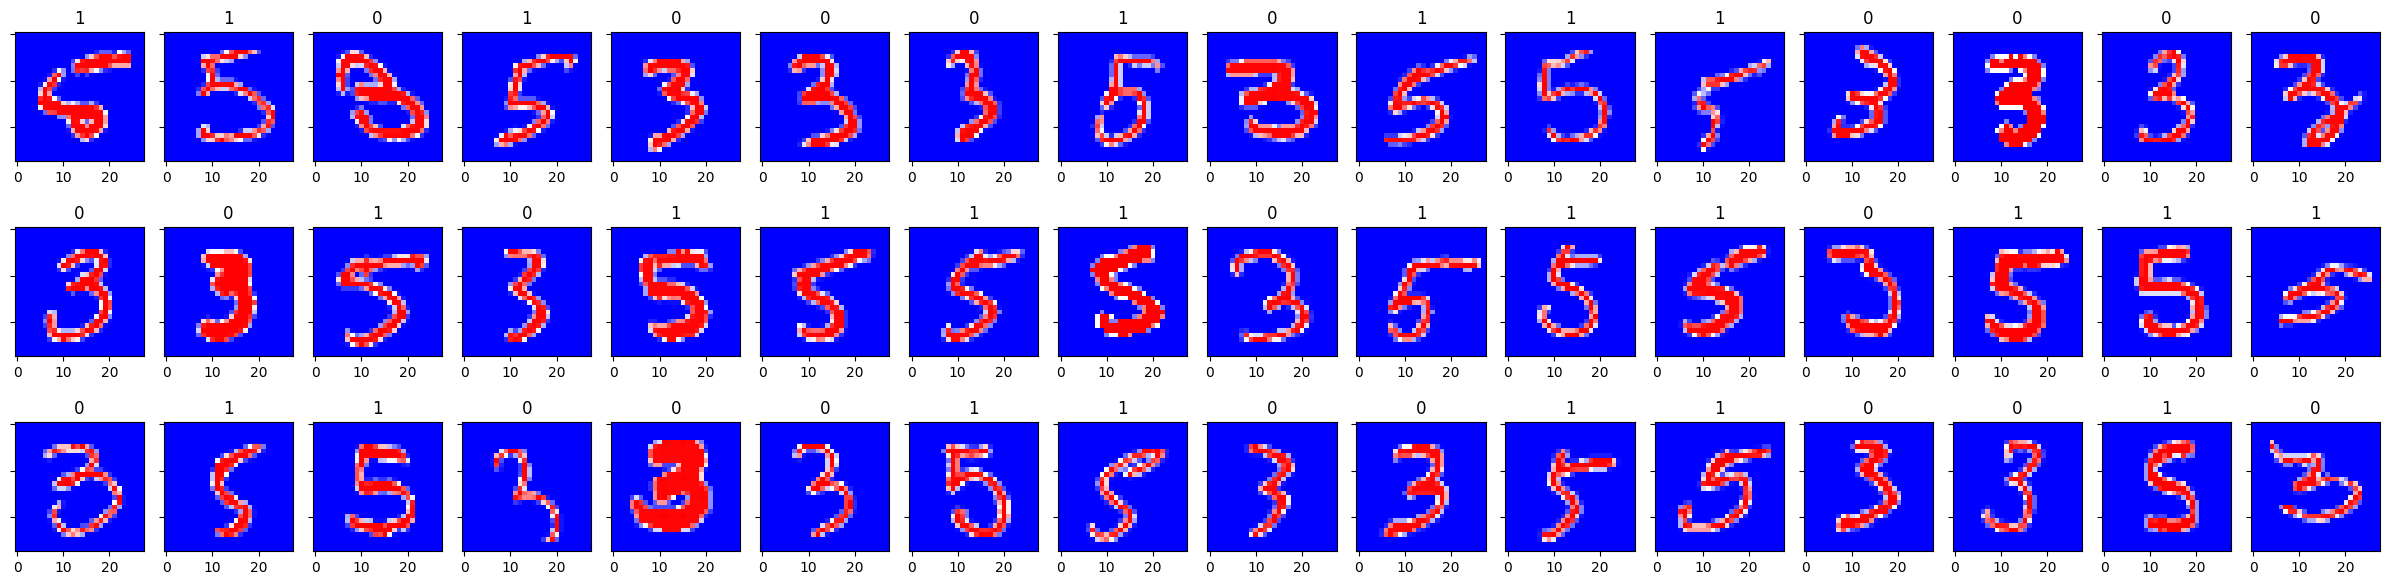

In [5]:
hh.plot_example(x_test, y_test)

# Train

In [6]:
seed = 314
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

augment = nn.Sequential(
    Noise(mean=0.05, scale=0.25, clip=True, p=0.7),
)

model = get_model()

cls_module = ClsModule(
    learning_rate=3e-3,  # BEST
    # weight_decay=3e-7,# 0.00001,
    weight_decay=3e-6,  # BEST?
    # weight_decay=0.0,
    noise_eps=EPS,
    adv_prob=0.0,
    # adv_prob=1.0,
    val_adv_prob=1.0,
    n_classes=N_CLASSES,
    augment=augment,
    backbone=model,
)

cls_module.to(device)
model = cls_module.backbone
cls_module(torch.zeros_like(x_test))  # sanity check + potential lazy initialization
pass

In [7]:
cls_module.train()

trainer = Trainer(
    accelerator="auto",
    # precision=16,
    # devices=1 if torch.cuda.is_available() else None,
    devices="auto",
    # max_epochs=2,
    # max_epochs=5,
    # max_epochs=10,
    max_epochs=15,  # this
    # max_epochs=20,
    callbacks=[TQDMProgressBar(refresh_rate=2)],
    logger=CSVLogger(save_dir=LOGS_DIR, version=VERSION),
)

trainer.fit(
    model=cls_module,
    datamodule=datamodule,
    # ckpt_path=f"{LOGS_DIR}lightning_logs/version_{version}/checkpoints/epoch=9-step=1130.ckpt",
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/miniconda/base/envs/wbnn/lib/python3.12/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/mnist_sf_model/lightning_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/usr/local/Caskroom/miniconda/base/envs/wbnn/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory logs/mnist_sf_model/lightning_logs/version_0/checkpoints exists and is not empty.

  | Name              | Type                       | Params
-----------------------------------------------------------------
0 | loss              | CrossEntropyLoss           | 0     
1 | augment           | Sequential                 | 0     
2 | backbone          | Sequential                 | 4.8 K 
3 | train_accuracy    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/wbnn/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/Caskroom/miniconda/base/envs/wbnn/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


# Inspect model

,train_acc,train_loss,val_adv_acc,val_adv_loss
epoch,,,,
10,NaN,NaN,0.911672,0.210809
11,0.995,0.025074,NaN,NaN
11,NaN,NaN,0.904311,0.230210
12,1.000,0.010265,NaN,NaN
12,0.995,0.028143,NaN,NaN
12,NaN,NaN,0.923239,0.204074
13,0.995,0.021573,NaN,NaN
13,NaN,NaN,0.910620,0.225676
14,0.995,0.020457,NaN,NaN


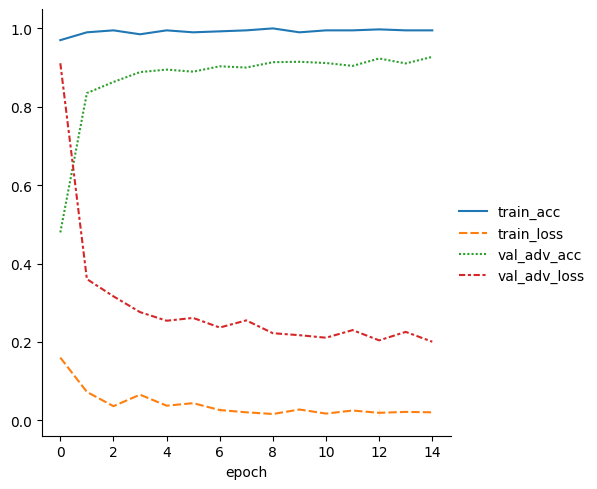

In [8]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics = metrics[["train_acc", "train_loss", "val_adv_acc", "val_adv_loss", "epoch"]]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").tail(10))
met = metrics[metrics.index >= 0] # first few epochs might be an outliers
sn.relplot(data=met, kind="line")

In [9]:
# Test on full test (PGD attack)
cls_module.to(device)
cls_module.eval()
trainer.test(cls_module, datamodule)
cls_module.eval()
cls_module.training

/usr/local/Caskroom/miniconda/base/envs/wbnn/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_adv_acc           0.92586749792099
      test_adv_loss          0.191068634390831
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


False

tensor(0.9257)

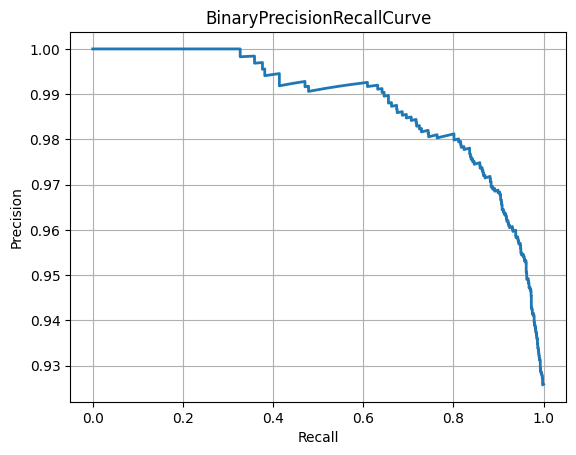

In [10]:
p, r, t = cls_module.reliability_curve.compute()
cls_module.reliability_curve.plot()
p.min()

In [ ]:
cls_module.to(device)
pass

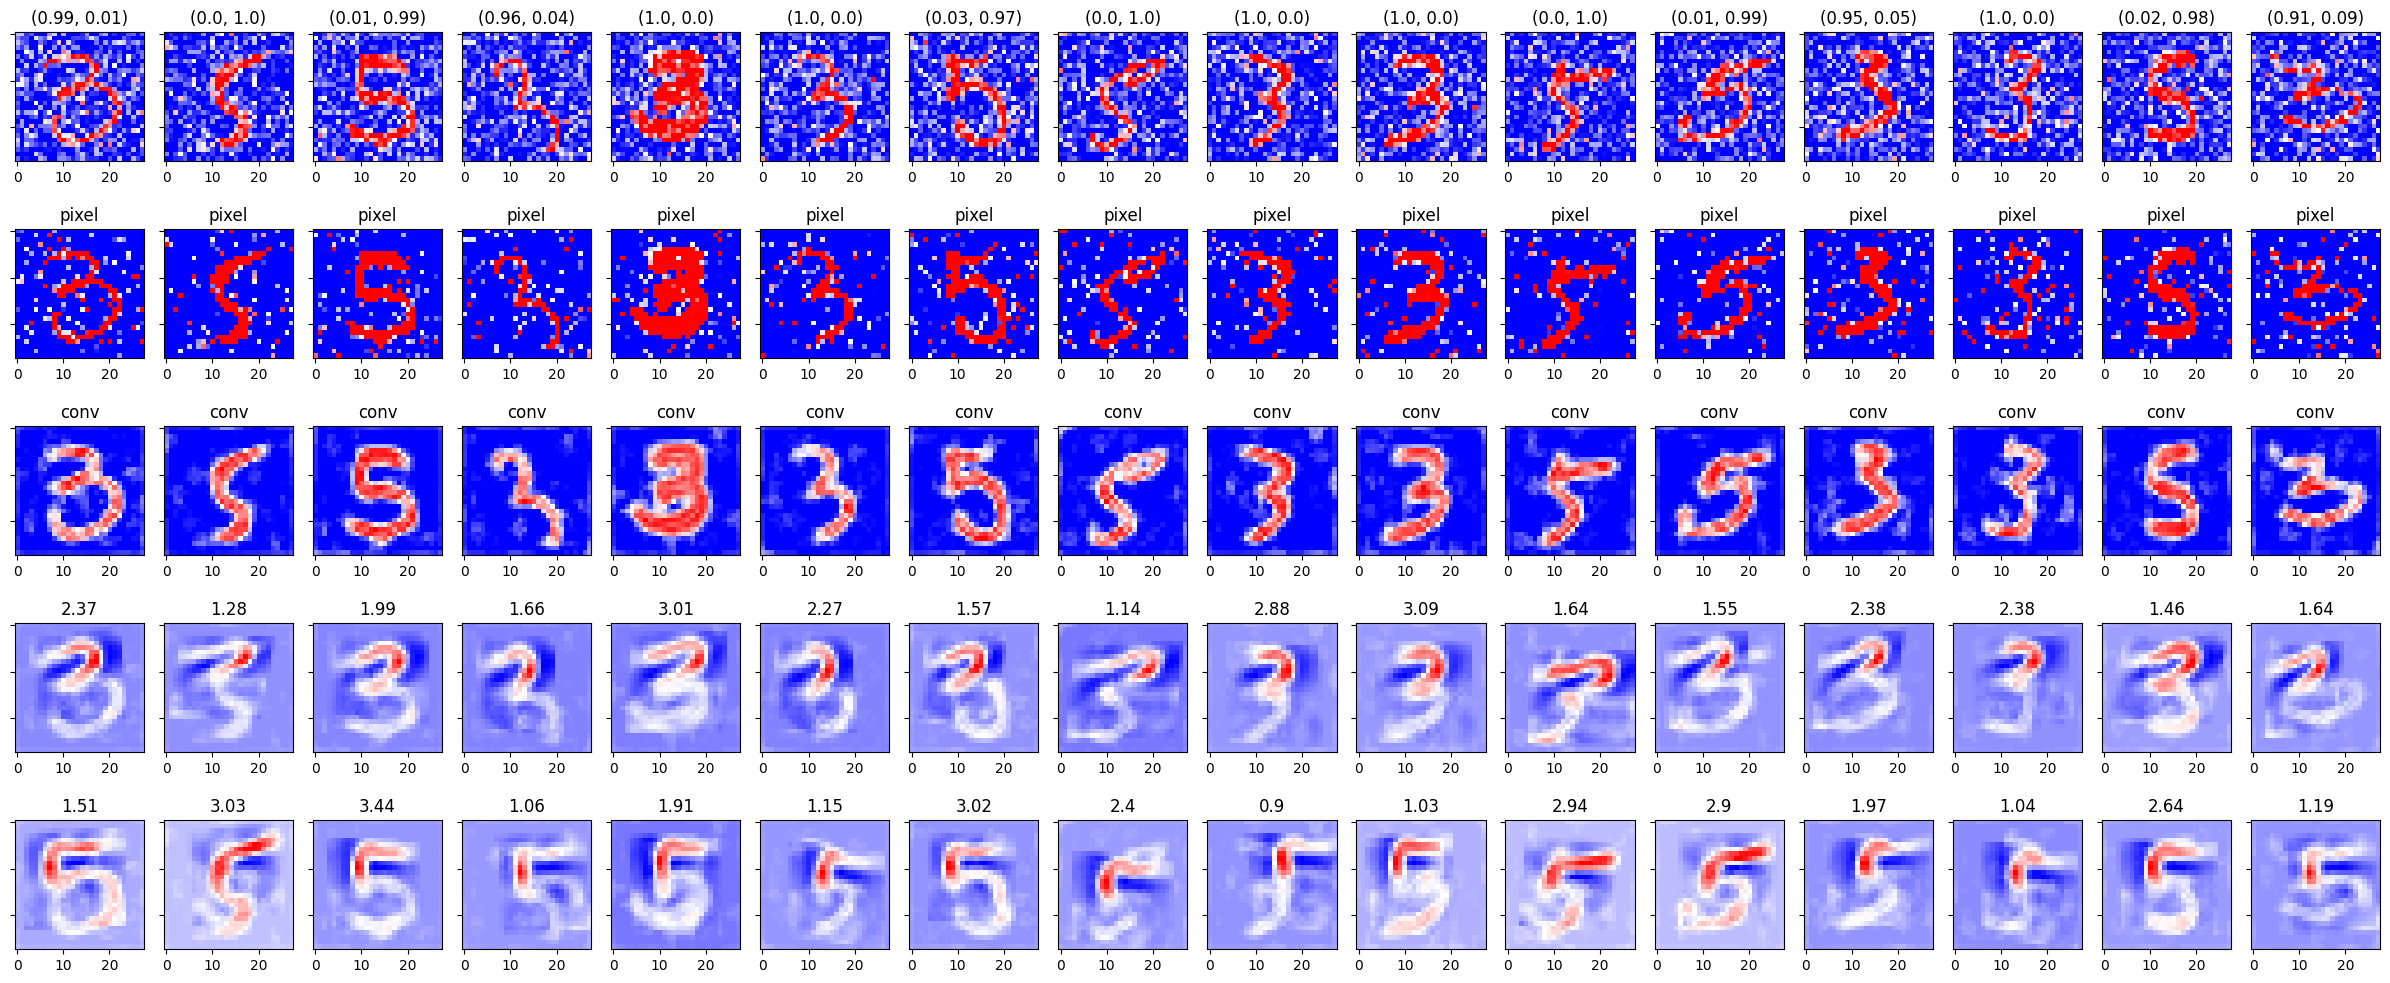

In [11]:
# noise = Noise(mean=0.05, scale=0.25, clip=True, p=1.)
xx = augment(x_test_small)
layer_vis, labels = visualize_processing_steps(model, xx)

hh.plot_example(layer_vis, y=labels, n_row=5)

Learned 2-step: TwoStepFunction(0.365, 0.556, 0.825, 0.681, scales=[0.001, 0.126, 0.28, 0.005])


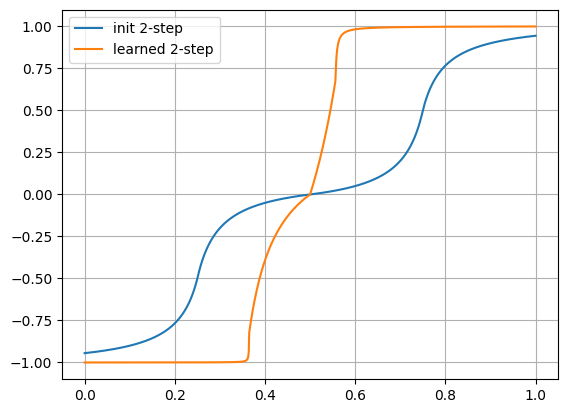

In [12]:
n_steps = 1000
thr = torch.tensor(range(n_steps + 1)) / n_steps

val_learned = model.pixel(thr.to(device)).cpu()
val_init = TwoStepFunction(10)(thr)
plt.plot(thr, val_init.detach(), label='init 2-step')
plt.plot(thr, val_learned.detach(), label='learned 2-step')
plt.legend()

print("Learned 2-step:", model.pixel)

ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

tensor(-0.2547) tensor(0.4362) 1.0


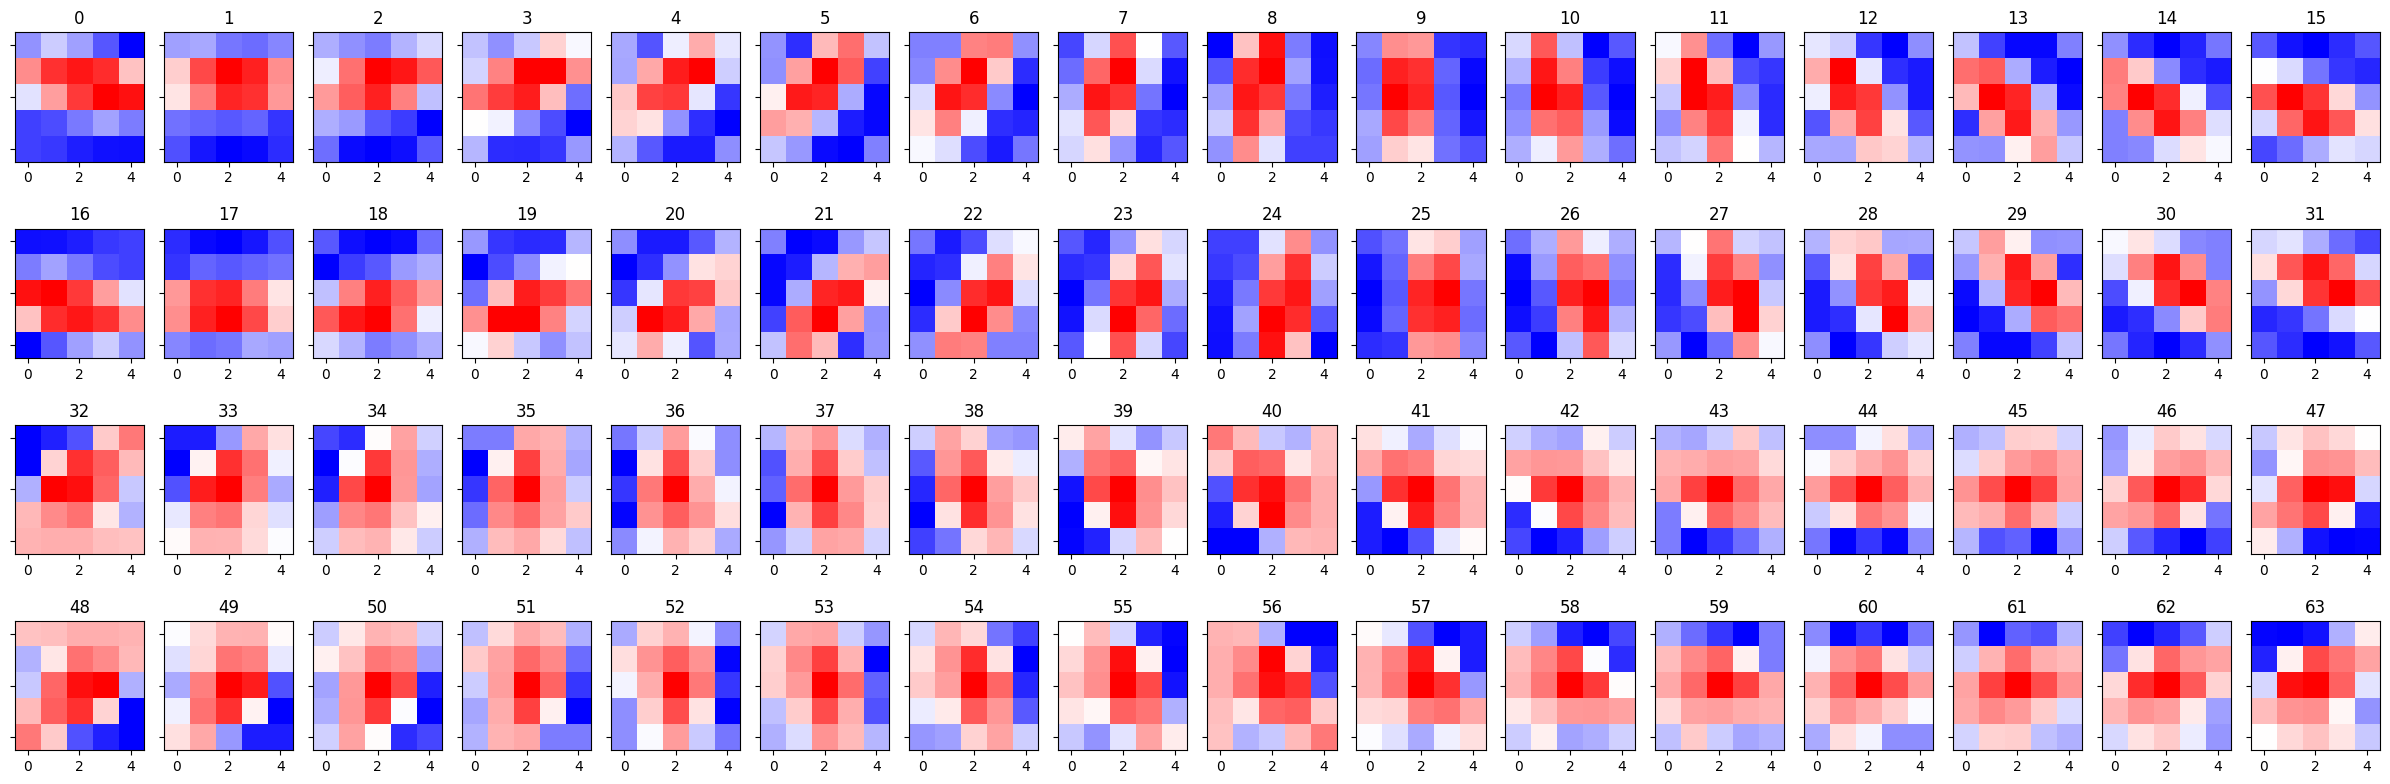

In [13]:
cc = model.conv.get_weight().detach().flatten(0, 1)
print(cc.min(), cc.max(), model.conv.scale.item())

hh.plot_example(cc, n_row=4, n_col=16)

-0.16233086585998535 0.24442115426063538 Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True) Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)


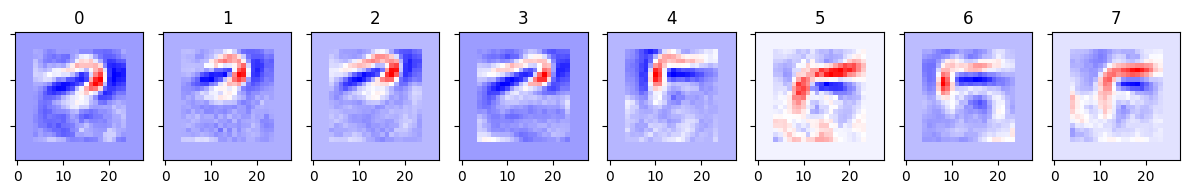

In [14]:
f = model.affine.get_features()
f = f.flatten(0, 1)[:, None]
print(f.min().item(), f.max().item(), model.affine.scale, model.affine.bias)

# hh.plot_example(f, list(range(len(f))), n_col=2, n_row=1)
hh.plot_example(f, list(range(len(f))), n_col=len(f), n_row=1)

tensor([[ 1.0700,  0.0000,  0.0000,  0.0000, -0.7800, -0.7100, -0.8000, -0.8100],
        [-0.8100, -0.7600, -0.8600, -0.8000,  1.0500,  0.0000,  0.0000,  0.0000]],
       grad_fn=<RoundBackward1>)


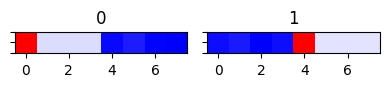

In [15]:
s = model.sparse.get_features()
print(s.round(decimals=2))
s = s.unflatten(1, (1, 1, -1))
hh.plot_example(s, n_row=1, n_col=N_CLASSES)

In [16]:
s = model.sparse.get_weight()
s

tensor([[[ 1.0709,  0.0000,  0.0000,  0.0000, -0.7792, -0.7100, -0.8023, -0.8149],
         [ 0.0000,  1.0709,  0.0000,  0.0000, -0.7792, -0.7100, -0.8023, -0.8149],
         [ 0.0000,  0.0000,  1.0709,  0.0000, -0.7792, -0.7100, -0.8023, -0.8149],
         [ 0.0000,  0.0000,  0.0000,  1.0709, -0.7792, -0.7100, -0.8023, -0.8149]],

        [[-0.8110, -0.7581, -0.8567, -0.7978,  1.0510,  0.0000,  0.0000,  0.0000],
         [-0.8110, -0.7581, -0.8567, -0.7978,  0.0000,  1.0510,  0.0000,  0.0000],
         [-0.8110, -0.7581, -0.8567, -0.7978,  0.0000,  0.0000,  1.0510,  0.0000],
         [-0.8110, -0.7581, -0.8567, -0.7978,  0.0000,  0.0000,  0.0000,  1.0510]]])

tensor(-0.1812) tensor(0.2943)


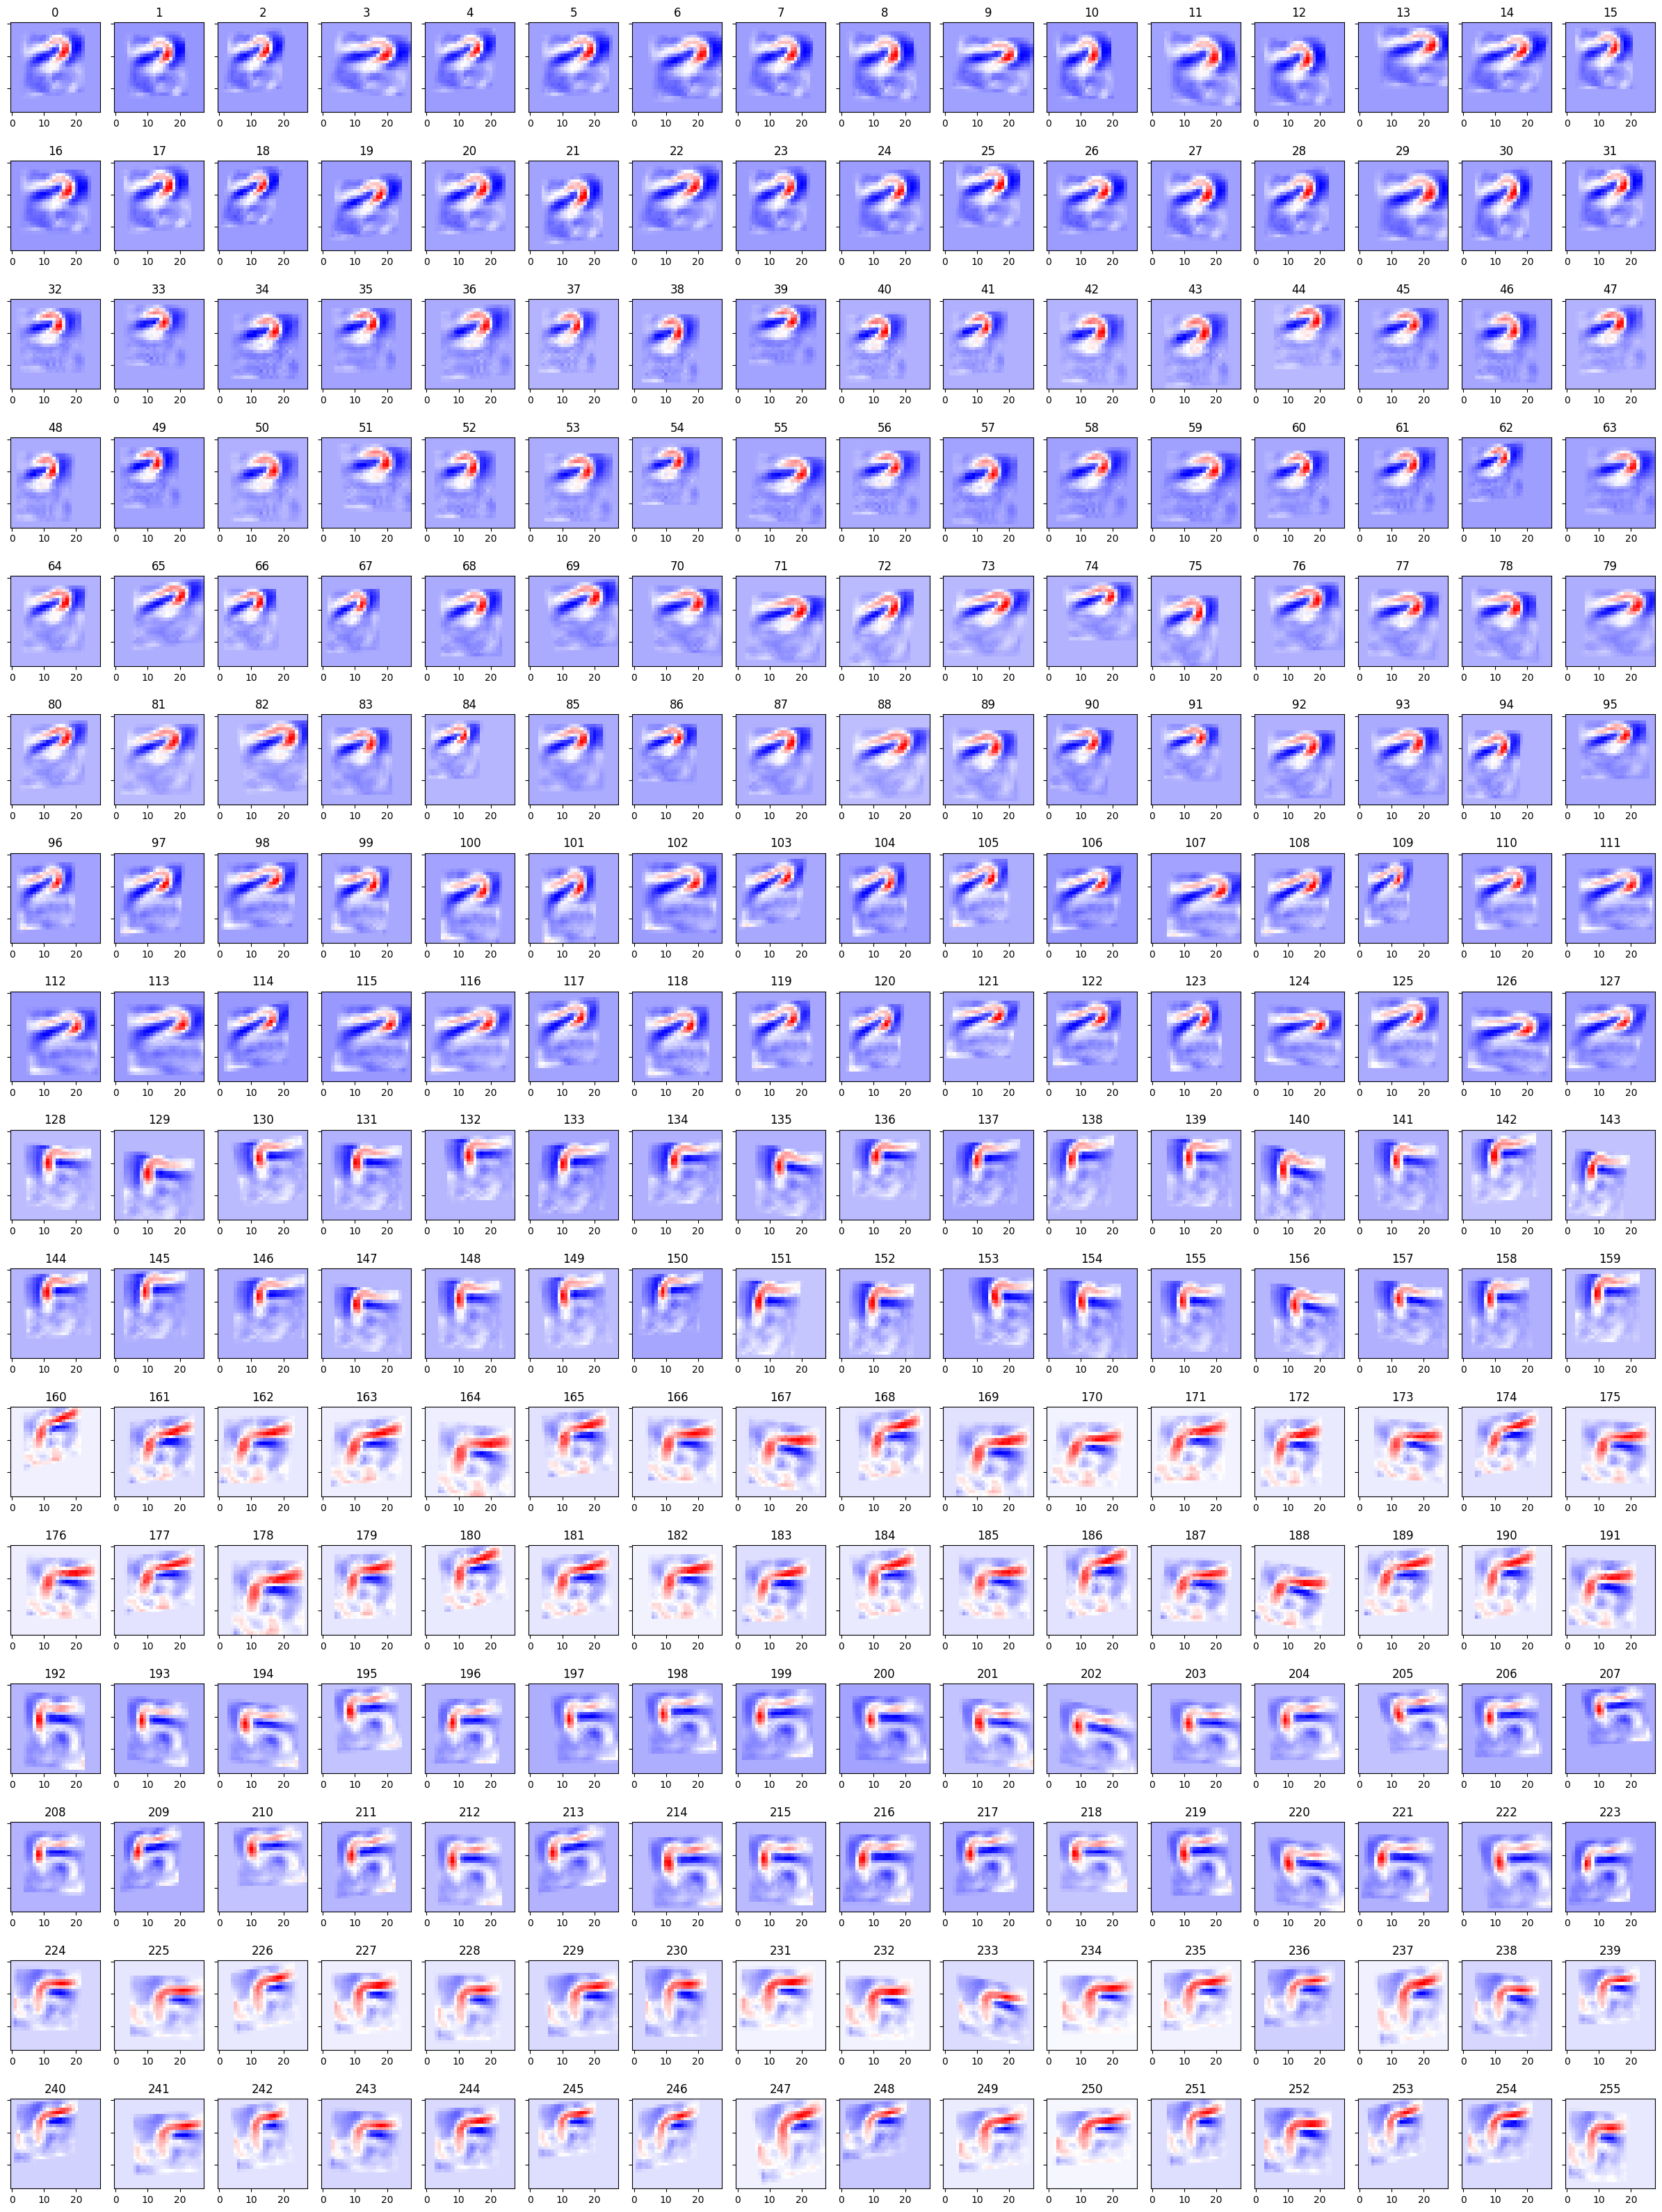

In [17]:
ff = model.affine.get_weight()
ff = ff.flatten(0, 1)

print(ff.min(), ff.max())

max_rows = 16
hh.plot_example(ff, list(range(len(ff))), n_col=16, n_row=min(max(ff.shape[0]//16, 2), max_rows))

In [18]:
poses = torch.cat(list(model.affine.sampler.poses))
poses.round(decimals=2)
poses[:, :, :2].min(), poses[:, :, :2].max(), poses.min(), poses.max()

(tensor(-0.2693, grad_fn=<MinBackward1>),
 tensor(1.2224, grad_fn=<MaxBackward1>),
 tensor(-2.4700, grad_fn=<MinBackward1>),
 tensor(3.2098, grad_fn=<MaxBackward1>))

# Save

In [19]:
if False:
# if True:
    save_path = MODEL_SAVE_PATH
    torch.save(model.state_dict(), save_path)